# Image Scoring Analysis (Set Images for Grid)

Analyzes user scoring behavior from the the set images, 33 that were used at first

3 main categories grouped:

1. **All Images** — Mean score & Mean click order per image  
2. **All Positions** — Mean score & Mean click order per grid position (combined across users)  
3. **Click Order vs Score** — Does click priority reflect perceived image quality?

---

## 1. Setup & Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', font_scale=1.0)
%matplotlib inline

## 2. Prep & Load Data

In [17]:
df = pd.read_csv('combo_results_all-2.csv')

df['Username'] = df['Username'].astype(str).str.zfill(5)

# parsing for pos
df['Page'] = df['Position'].str.extract(r'P(\d)').astype(int)
df['Row']  = df['Position'].str.extract(r'\((\d),').astype(int)
df['Col']  = df['Position'].str.extract(r',(\d)\)').astype(int)

# label grid without page (coords)
df['GridPos'] = '(' + df['Row'].astype(str) + ',' + df['Col'].astype(str) + ')'

# click order
df['ClickOrderNum'] = pd.to_numeric(df['ClickOrder'], errors='coerce')

# binary flags
df['Clicked']   = (df['Moves'] > 0).astype(int)
df['MultiMove'] = (df['Moves'] > 1).astype(int)

print(f"Loaded {len(df)} rows, {df['Username'].nunique()} users, {df['Image'].nunique()} images")
df.head(10)

Loaded 198 rows, 6 users, 33 images


,Username,Protocol,Timestamp,Image,Position,Score,Moves,ClickOrder,Page,Row,Col,GridPos,ClickOrderNum,Clicked,MultiMove
0,00001,Combo,"1/31/2026, 4:56:15 PM",target_000055,"P1:(1,1)",7,1,3,1,1,1,"(1,1)",3.0,1,0
1,00001,Combo,"1/31/2026, 4:56:15 PM",target_000274,"P1:(1,2)",7,1,4,1,1,2,"(1,2)",4.0,1,0
2,00001,Combo,"1/31/2026, 4:56:15 PM",target_000335,"P1:(1,3)",4,1,5,1,1,3,"(1,3)",5.0,1,0
3,00001,Combo,"1/31/2026, 4:56:15 PM",target_000426,"P1:(2,1)",4,1,7,1,2,1,"(2,1)",7.0,1,0
4,00001,Combo,"1/31/2026, 4:56:15 PM",target_000515,"P1:(2,3)",3,1,6,1,2,3,"(2,3)",6.0,1,0
5,00001,Combo,"1/31/2026, 4:56:15 PM",target_000735,"P1:(3,1)",3,1,8,1,3,1,"(3,1)",8.0,1,0
6,00001,Combo,"1/31/2026, 4:56:15 PM",target_000772,"P1:(3,2)",6,2,2,1,3,2,"(3,2)",2.0,1,1
7,00001,Combo,"1/31/2026, 4:56:15 PM",target_000818,"P1:(3,3)",7,1,1,1,3,3,"(3,3)",1.0,1,0
8,00001,Combo,"1/31/2026, 4:56:15 PM",target_000819,"P2:(1,1)",5,1,5,2,1,1,"(1,1)",5.0,1,0
9,00001,Combo,"1/31/2026, 4:56:15 PM",target_000824,"P2:(1,2)",2,1,6,2,1,2,"(1,2)",6.0,1,0


## 3. Data Check

In [11]:
print("Score distribution:")
print(df['Score'].describe().to_string())
print(f"\nMoves value counts:\n{df['Moves'].value_counts().sort_index().to_string()}")
print(f"\nRows per user:\n{df.groupby('Username').size().to_string()}")
print(f"\nNon-click rate: {(1 - df['Clicked'].mean()) * 100:.1f}%")

Score distribution:
count    198.000000
mean       5.328283
std        2.079220
min        1.000000
25%        3.000000
50%        6.000000
75%        7.000000
max       10.000000

Moves value counts:
Moves
0     12
1    166
2     19
3      1

Rows per user:
Username
00001    33
00003    33
00004    33
00005    33
00006    33
00007    33

Non-click rate: 6.1%


## 4. Chart 1 — All Images: Mean score, Mean click order & Mean moves

Each image has three bars (sorted by descending mean score), and all are across all users:  
- **Blue** = mean score
- **Orange** = mean click order 
- **Green** = mean moves

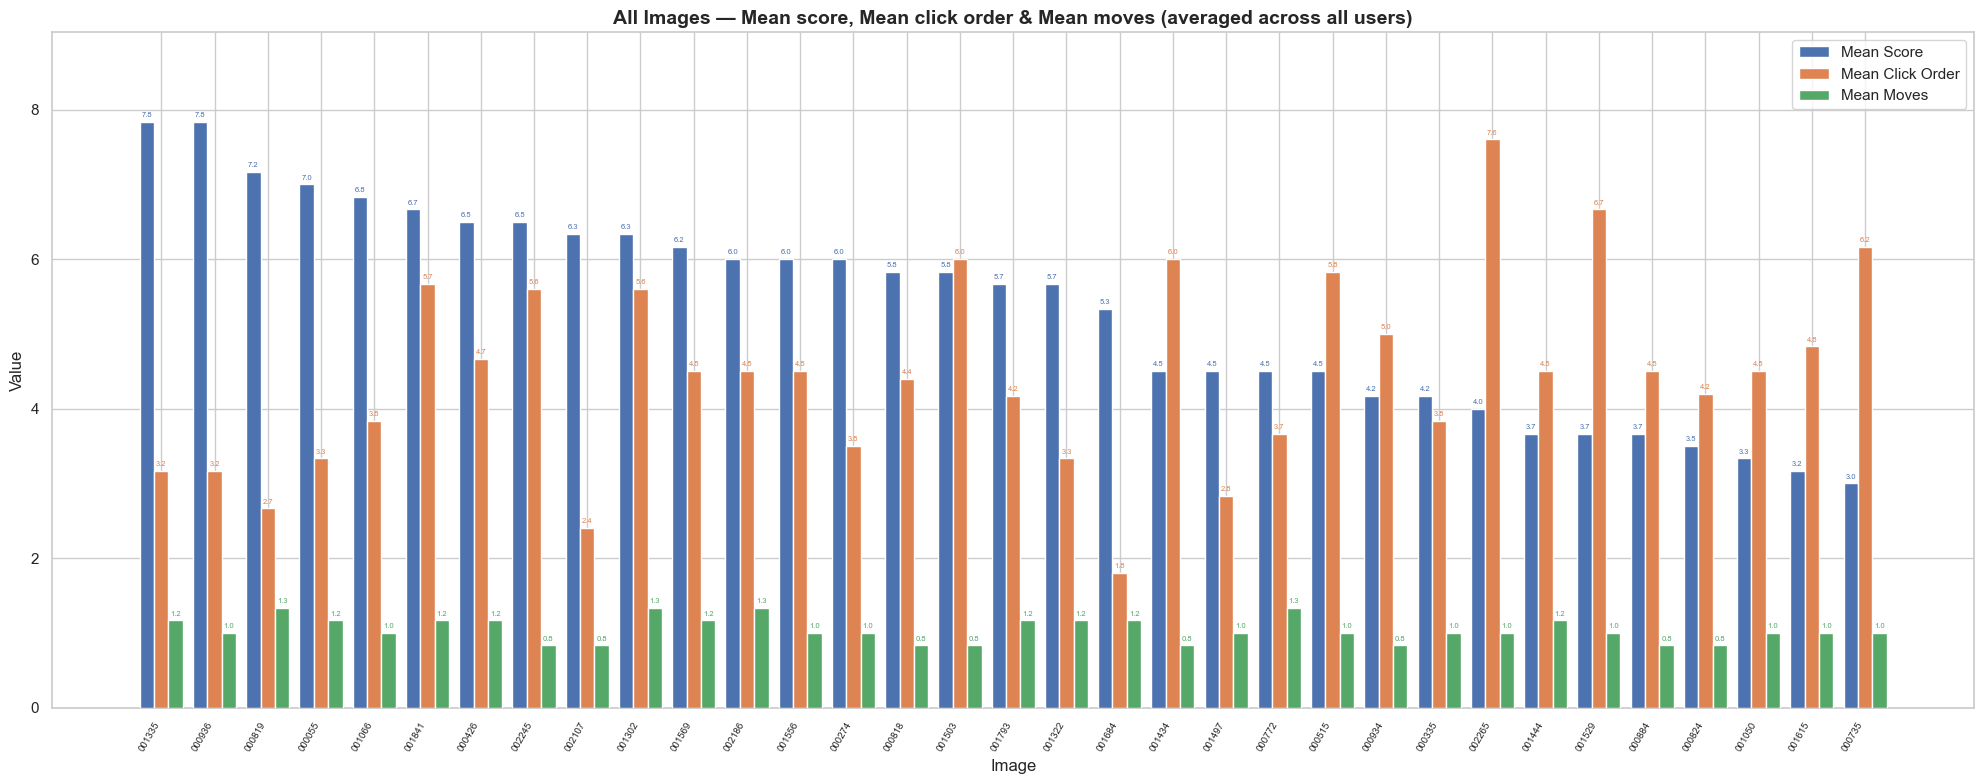

In [20]:
# aggregate per image
img_stats = df.groupby('Image').agg(
    mean_score=('Score', 'mean'),
    mean_click=('ClickOrderNum', 'mean'),
    mean_moves=('Moves', 'mean'),
).sort_values('mean_score', ascending=False)

# plot
fig, ax = plt.subplots(figsize=(20, 8))
x = np.arange(len(img_stats))
width = 0.27

bars_score = ax.bar(x - width, img_stats['mean_score'], width,
                    label='Mean Score', color='#4C72B0', edgecolor='white', zorder=3)
bars_click = ax.bar(x,         img_stats['mean_click'], width,
                    label='Mean Click Order', color='#DD8452', edgecolor='white', zorder=3)
bars_moves = ax.bar(x + width, img_stats['mean_moves'], width,
                    label='Mean Moves', color='#55A868', edgecolor='white', zorder=3)

# value labels
for bars, color in [(bars_score, '#4C72B0'), (bars_click, '#DD8452'), (bars_moves, '#55A868')]:
    for b in bars:
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05,
                f'{b.get_height():.1f}', ha='center', va='bottom', fontsize=5.5, color=color)

ax.set_xticks(x)
ax.set_xticklabels(img_stats.index.str.replace('target_', ''), rotation=60, ha='right', fontsize=7)
ax.set_ylabel('Value')
ax.set_xlabel('Image')
ax.set_title('All Images — Mean score, Mean click order & Mean moves (averaged across all users)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(0, max(img_stats['mean_score'].max(), img_stats['mean_click'].max()) + 1.2)

plt.tight_layout()
plt.show()

## 5. Chart 2 — By positions: Mean score, Mean click order & Mean moves (combined users)

Each bar triplet shows one grid position (e.g. P1:(1,1) = Page 1, Row 1, Col 1).  
All three metrics are averaged across **all users**.  
Dashed vertical lines separate the four pages.

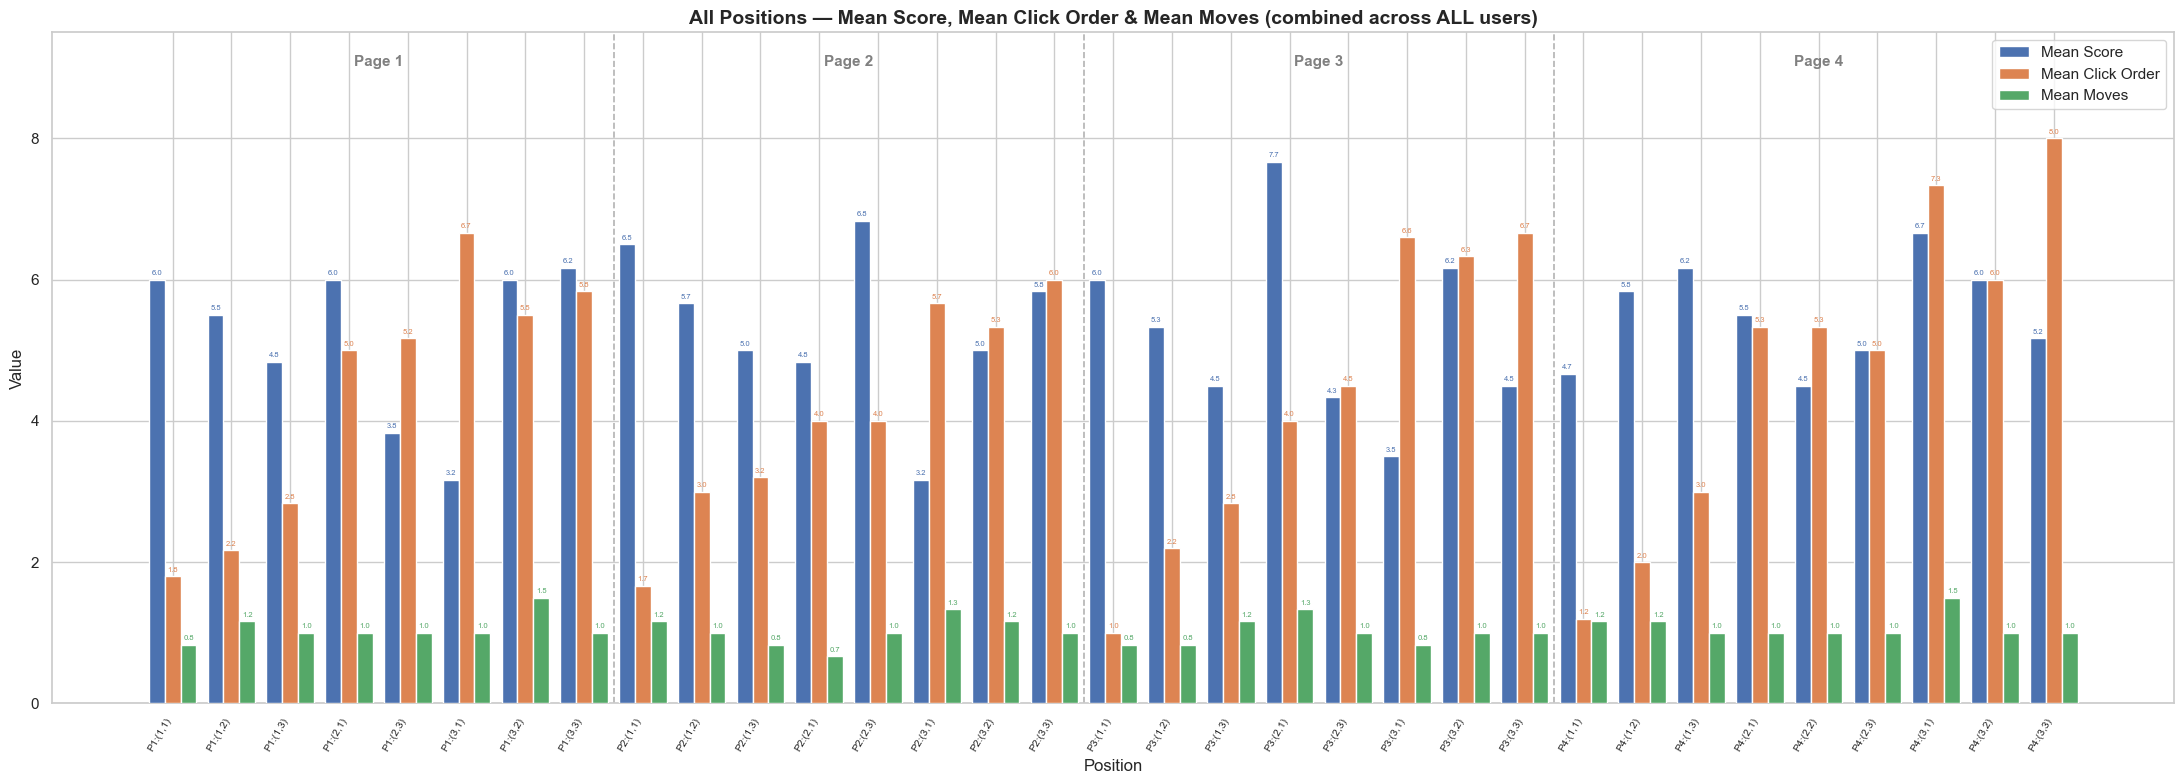

In [19]:
# aggregate per position
pos_stats = df.groupby('Position').agg(
    mean_score=('Score', 'mean'),
    mean_click=('ClickOrderNum', 'mean'),
    mean_moves=('Moves', 'mean'),
).copy()

# parse 
pos_stats['Page'] = pos_stats.index.str.extract(r'P(\d)')[0].astype(int).values
pos_stats['Row']  = pos_stats.index.str.extract(r'\((\d),')[0].astype(int).values
pos_stats['Col']  = pos_stats.index.str.extract(r',(\d)\)')[0].astype(int).values
pos_stats = pos_stats.sort_values(['Page', 'Row', 'Col'])

fig, ax = plt.subplots(figsize=(22, 8))
x = np.arange(len(pos_stats))
width = 0.27

bars_score = ax.bar(x - width, pos_stats['mean_score'], width,
                    label='Mean Score', color='#4C72B0', edgecolor='white', zorder=3)
bars_click = ax.bar(x,         pos_stats['mean_click'], width,
                    label='Mean Click Order', color='#DD8452', edgecolor='white', zorder=3)
bars_moves = ax.bar(x + width, pos_stats['mean_moves'], width,
                    label='Mean Moves', color='#55A868', edgecolor='white', zorder=3)

for bars, color in [(bars_score, '#4C72B0'), (bars_click, '#DD8452'), (bars_moves, '#55A868')]:
    for b in bars:
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05,
                f'{b.get_height():.1f}', ha='center', va='bottom', fontsize=5.5, color=color)

ax.set_xticks(x)
ax.set_xticklabels(pos_stats.index, rotation=60, ha='right', fontsize=7.5)
ax.set_ylabel('Value')
ax.set_xlabel('Position')
ax.set_title('All Positions — Mean score, Mean click order & Mean moves (combined across ALL users)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(0, max(pos_stats['mean_score'].max(), pos_stats['mean_click'].max()) + 1.5)

# page dividers
page_boundaries = []
for i in range(1, len(pos_stats)):
    if pos_stats['Page'].iloc[i] != pos_stats['Page'].iloc[i-1]:
        page_boundaries.append(i - 0.5)
for bnd in page_boundaries:
    ax.axvline(bnd, color='grey', ls='--', lw=1.2, alpha=0.6)

# page labels
page_starts = [0] + [int(b + 0.5) for b in page_boundaries] + [len(pos_stats)]
for i in range(len(page_starts) - 1):
    mid = (page_starts[i] + page_starts[i+1] - 1) / 2
    ax.text(mid, ax.get_ylim()[1] * 0.95, f'Page {i+1}',
            ha='center', fontsize=11, fontweight='bold', color='grey')

plt.tight_layout()
plt.show()

## 6. Chart 3 — Aggregate Grid Positions

This chart collapses across pages so that **all (1,1) slots are combined**, **all (1,2) slots are combined**, etc.  
Looks to investigage question regarding whether position of image affects anything -- here,  image doesn't matter, nor does page

Quick note to make: (2,2) has 1/4 data of rest, since it's only displayed on one page, as this is also being investigated -- does hole in center/no hole affect anything?

Positions are sorted row-by-row: (1,1), (1,2), (1,3), (2,1), … , (3,3).  

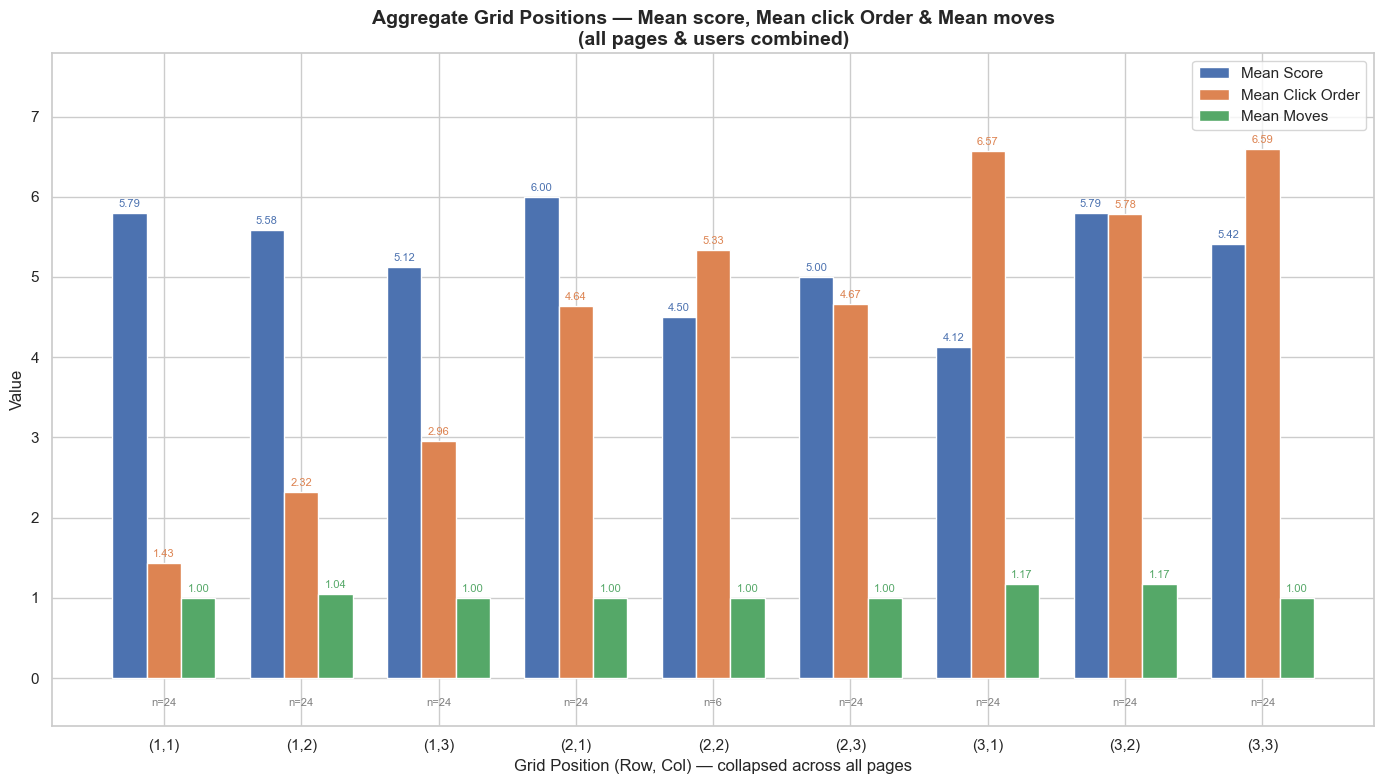

In [22]:
# aggregate
grid_stats = df.groupby('GridPos').agg(
    mean_score=('Score', 'mean'),
    mean_click=('ClickOrderNum', 'mean'),
    mean_moves=('Moves', 'mean'),
    n=('Score', 'count'),
).copy()

# sort
grid_stats['Row'] = grid_stats.index.str.extract(r'\((\d),')[0].astype(int).values
grid_stats['Col'] = grid_stats.index.str.extract(r',(\d)\)')[0].astype(int).values
grid_stats = grid_stats.sort_values(['Row', 'Col'])

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(grid_stats))
width = 0.25

bars_score = ax.bar(x - width, grid_stats['mean_score'], width,
                    label='Mean Score', color='#4C72B0', edgecolor='white', zorder=3)
bars_click = ax.bar(x,         grid_stats['mean_click'], width,
                    label='Mean Click Order', color='#DD8452', edgecolor='white', zorder=3)
bars_moves = ax.bar(x + width, grid_stats['mean_moves'], width,
                    label='Mean Moves', color='#55A868', edgecolor='white', zorder=3)

# vals
for bars, color in [(bars_score, '#4C72B0'), (bars_click, '#DD8452'), (bars_moves, '#55A868')]:
    for b in bars:
        ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05,
                f'{b.get_height():.2f}', ha='center', va='bottom', fontsize=8, color=color)

for i, (idx, row) in enumerate(grid_stats.iterrows()):
    ax.text(i, -0.35, f'n={int(row["n"])}', ha='center', fontsize=8, color='grey')

ax.set_xticks(x)
ax.set_xticklabels(grid_stats.index, fontsize=11)
ax.set_ylabel('Value')
ax.set_xlabel('Grid Position (Row, Col) — collapsed across all pages')
ax.set_title('Aggregate Grid Positions — Mean score, Mean click Order & Mean moves\n(all pages & users combined)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.set_ylim(-0.6, max(grid_stats['mean_score'].max(), grid_stats['mean_click'].max()) + 1.2)

plt.tight_layout()
plt.show()

## 7. Chart 4 — Click Order vs Score

### Mainly looking at whether users gravitate towards images they score higher/have bias with how early they rate an image

For reference, every trial, a user sees a grid of images and clicks them in some order:
- **Click Order 1** = the image they clicked **first**
- **Click Order 9** = the image they clicked **last**

Each image will get a **Score** (1–10) from the user.

If users are drawn to "better" images first, we'd expect a **negative correlation** — 
low click orders paired with high scores.

Quick note: This only keeps track of the **first** click by the user, not any later modifications done

### How the two panels work

| Panel | What it shows |
|-------|---------------|
| **Left — Scatter & regression** | Each dot is one user×image observation. X = when they clicked it, Y = what score they gave it. The red OLS line shows the linear trend. The shaded band is the 95% confidence interval. |
| **Right — Mean ccore per Click order** | Collapses the scatter into averages: the mean score of all images clicked 1st, 2nd, 3rd, etc. Error bars are standard error. The dashed red line shows the trend across these means. |

### Statistical tests reported

| Statistic | What it measures |
|-----------|-----------------|
| **Pearson r** | Linear correlation (−1 to +1). Negative = earlier clicks → higher scores. |
| **p-value** | Probability this correlation is due to chance. < 0.05 is conventionally "significant". |
| **Spearman ρ** | Rank-based correlation — same idea but robust to outliers and non-linear patterns. |

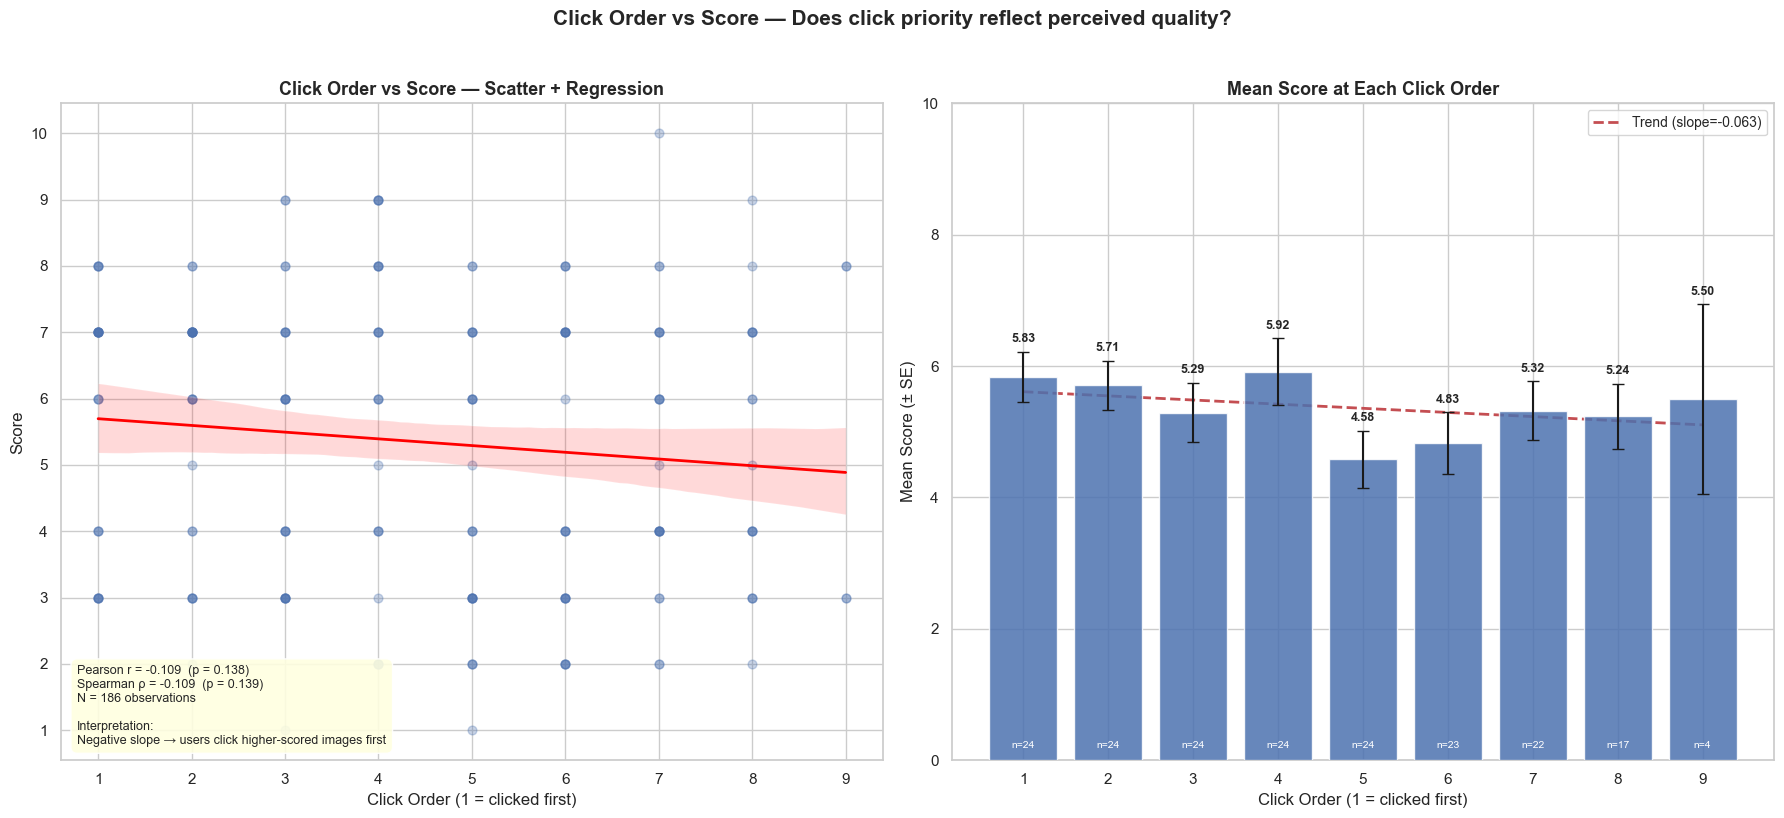

In [25]:
# filter to images actually clicked
clicked = df.dropna(subset=['ClickOrderNum']).copy()

fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(18, 8))

# Left panel: Scatter + OLS regression line
sns.regplot(data=clicked, x='ClickOrderNum', y='Score',
            scatter_kws={'alpha': 0.3, 's': 40, 'color': '#4C72B0'},
            line_kws={'color': 'red', 'lw': 2},
            ax=ax_left)

# correlation
r_pearson,  p_pearson  = stats.pearsonr(clicked['ClickOrderNum'], clicked['Score'])
r_spearman, p_spearman = stats.spearmanr(clicked['ClickOrderNum'], clicked['Score'])

ax_left.set_xlabel('Click Order (1 = clicked first)', fontsize=12)
ax_left.set_ylabel('Score', fontsize=12)
ax_left.set_title('Click Order vs Score — Scatter + Regression', fontsize=13, fontweight='bold')
ax_left.set_xticks(range(1, 10))
ax_left.set_yticks(range(1, 11))

stats_text = (
    f'Pearson r = {r_pearson:.3f}  (p = {p_pearson:.3f})\n'
    f'Spearman ρ = {r_spearman:.3f}  (p = {p_spearman:.3f})\n'
    f'N = {len(clicked)} observations\n\n'
    f'Interpretation:\n'
    f'{"Negative slope → users click higher-scored images first" if r_pearson < 0 else "Positive slope → users click lower-scored images first"}'
)
ax_left.text(0.02, 0.02, stats_text, transform=ax_left.transAxes, fontsize=9,
             verticalalignment='bottom',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.9))

# Right panel: Mean score at each click order position
click_means = clicked.groupby('ClickOrderNum')['Score'].agg(['mean', 'std', 'count'])
click_means['se'] = click_means['std'] / np.sqrt(click_means['count'])

bars = ax_right.bar(click_means.index, click_means['mean'],
                    yerr=click_means['se'], capsize=4,
                    color='#4C72B0', edgecolor='white', alpha=0.85, zorder=3)

for bar, (idx, row) in zip(bars, click_means.iterrows()):
    ax_right.text(bar.get_x() + bar.get_width()/2, bar.get_height() + row['se'] + 0.1,
                  f'{row["mean"]:.2f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax_right.text(bar.get_x() + bar.get_width()/2, 0.15,
                  f'n={int(row["count"])}', ha='center', va='bottom', fontsize=7.5, color='white')

# trend line 
z = np.polyfit(click_means.index, click_means['mean'], 1)
xfit = np.linspace(click_means.index.min(), click_means.index.max(), 100)
ax_right.plot(xfit, np.polyval(z, xfit), 'r--', lw=2, label=f'Trend (slope={z[0]:.3f})')

ax_right.set_xlabel('Click Order (1 = clicked first)', fontsize=12)
ax_right.set_ylabel('Mean Score (± SE)', fontsize=12)
ax_right.set_title('Mean Score at Each Click Order', fontsize=13, fontweight='bold')
ax_right.set_xticks(range(1, 10))
ax_right.set_ylim(0, 10)
ax_right.legend(fontsize=10)

fig.suptitle('Click Order vs Score — Does click priority reflect perceived quality?',
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 8. Summary Statistics

Quick notes:

1) ANOVA: Analysis of Variance, basically compares means
2) Click order w/ Pearson & Spearman, Pearson measures strength/direction of linear relationships & Spearmanis similar, but relationship doesn't have to be linear, both have range -1 to 1
3) Kruskal-Wallis, uses ranks instead of mean values, also another test if data isn't normal
4) Non-click rate, self explanatory, rate at which images weren't rated
5) Inter-rater, measures degree to which tests like Pearson/Spearman are correlated, basically are they similar or no
 

In [28]:
# score
print(f"\nOverall Score: Mean={df['Score'].mean():.2f}, SD={df['Score'].std():.2f}, Median={df['Score'].median():.0f}")
print(f"Overall Moves: Mean={df['Moves'].mean():.2f}, SD={df['Moves'].std():.2f}")

# page ANOVA
groups = [df[df['Page']==p]['Score'].values for p in [1,2,3,4]]
f_stat, p_val = stats.f_oneway(*groups)
print(f"\nPage Effect on Score (One-way ANOVA): F={f_stat:.3f}, p={p_val:.4f}")
for p_num in [1,2,3,4]:
    m = df[df['Page']==p_num]['Score'].mean()
    s = df[df['Page']==p_num]['Score'].std()
    print(f"  Page {p_num}: M={m:.2f}, SD={s:.2f}")

# click order
r_pearson,  p_pearson  = stats.pearsonr(
    df.dropna(subset=['ClickOrderNum'])['ClickOrderNum'],
    df.dropna(subset=['ClickOrderNum'])['Score'])
r_spearman, p_spearman = stats.spearmanr(
    df.dropna(subset=['ClickOrderNum'])['ClickOrderNum'],
    df.dropna(subset=['ClickOrderNum'])['Score'])
print(f"\nClick Order vs Score:")
print(f"  Pearson r = {r_pearson:.3f}, p = {p_pearson:.4f}")
print(f"  Spearman ρ = {r_spearman:.3f}, p = {p_spearman:.4f}")

# click order Kruskal-Wallis
clicked_df = df.dropna(subset=['ClickOrderNum']).copy()
clicked_df['ClickBin'] = pd.cut(clicked_df['ClickOrderNum'], bins=[0,2,4,6,10],
                                 labels=['1-2','3-4','5-6','7+'])
grps = [g['Score'].values for _, g in clicked_df.groupby('ClickBin')]
h_stat, h_p = stats.kruskal(*grps)
print(f"  Kruskal-Wallis across click bins: H={h_stat:.3f}, p={h_p:.4f}")

# non-click rate
nc_rate = (1 - df['Clicked'].mean()) * 100
print(f"\nNon-Click Rate: {nc_rate:.1f}%")

# inter-rater
user_scores = df.pivot_table(values='Score', index='Image', columns='Username')
corr = user_scores.corr()
mean_corr = corr.values[np.triu_indices_from(corr.values, k=1)].mean()
print(f"\nInter-Rater Mean Pairwise Correlation: {mean_corr:.3f}")


Overall Score: Mean=5.33, SD=2.08, Median=6
Overall Moves: Mean=1.05, SD=0.42

Page Effect on Score (One-way ANOVA): F=0.219, p=0.8834
  Page 1: M=5.19, SD=2.20
  Page 2: M=5.35, SD=2.07
  Page 3: M=5.25, SD=2.10
  Page 4: M=5.50, SD=2.01

Click Order vs Score:
  Pearson r = -0.109, p = 0.1383
  Spearman ρ = -0.109, p = 0.1394
  Kruskal-Wallis across click bins: H=6.438, p=0.0921

Non-Click Rate: 6.1%

Inter-Rater Mean Pairwise Correlation: 0.379
